In [1]:
# !pip install pycaret

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
import pandas as pd

def detect_stress_level(row):
    """
    Function to detect stress level from a row of physiological data collected from wearables
    incorporating HRV, recovery score, resting heart rate, blood oxygen, and REM duration.
    """
    # Assuming thresholds for recovery score
    recovery_high_threshold = 70  # percentage, threshold for 'high' recovery indicating relaxation
    recovery_low_threshold = 30  # percentage, threshold for 'low' recovery indicating stress

    # Assuming thresholds for heart rate variability (HRV)
    hrv_high_threshold = 60  # ms, threshold for 'high' HRV indicating relaxation
    hrv_low_threshold = 40  # ms, threshold for 'low' HRV indicating stress

    # Map the physiological signals to algorithm variables
    recovery_score = row['Recovery score %']
    hrv = row['Heart rate variability (ms)']
    hr = row['Resting heart rate (bpm)']
    bo = row['Blood oxygen %']
    rem = row['REM duration (min)']

    # Determine BWV based on recovery score and HRV
    bwv = 'low' if (pd.notnull(recovery_score) and recovery_score >= recovery_high_threshold) or \
                   (pd.notnull(hrv) and hrv >= hrv_high_threshold) else 'high'

    # Initialize timers as binary flags based on the data
    t1 = 1 if pd.notnull(row['Cycle start time']) else 0
    t2 = 1 if row['Asleep duration (min)'] > 0 else 0
    t3 = 1 if pd.notnull(row['Cycle end time']) else 0

    # Apply the algorithm with the updated conditions
    if bwv == 'low' and t1 == 1:
        # User is in light sleep or just went to bed
        return 0
        # return 'Low'
    elif bwv == 'high' and t2 == 1:
        # User in deep sleep (assuming high HR and low BO indicates deep sleep)
        if hr > 60 and bo < 95:  # Example thresholds for HR and BO during deep sleep
            # return 'High'
            return 2
        else:
            # return 'Medium'
            return 1
    elif t2 == 1 and rem > 0:
        # User is in REM sleep (REM duration > 0)
        # return 'Medium'
        return 1
    elif t3 == 1:
        # User woke up
        # return 'Low' if bo >= 95 else 'High'  # Assuming high blood oxygen indicates relaxed waking
        return 0 if bo>=95 else 2
    else:
        # If none of the conditions are met
        # return 'Medium'
        return 1

# Apply the revised function to each row and create a new column for stress level

dataset = pd.read_csv("physiological_cycles.csv")
dataset['Stress Level'] = dataset.apply(detect_stress_level, axis=1)

# Display the first few rows of the dataset with the new Stress Level column
dataset[['Cycle start time', 'Recovery score %', 'Heart rate variability (ms)',
      'Resting heart rate (bpm)', 'Blood oxygen %', 'REM duration (min)',
      'Cycle end time', 'Stress Level']].head()


,Cycle start time,Recovery score %,Heart rate variability (ms),Resting heart rate (bpm),Blood oxygen %,REM duration (min),Cycle end time,Stress Level
0,2024-04-19 04:14:09,47.0,52.0,59.0,97.00,106.0,NaN,1
1,2024-04-18 04:17:05,NaN,NaN,NaN,NaN,NaN,2024-04-19 04:14:09,2
2,2024-04-17 04:17:05,34.0,36.0,62.0,92.33,124.0,2024-04-18 04:17:05,2
3,2024-04-16 05:53:38,7.0,43.0,54.0,97.00,35.0,2024-04-17 04:17:05,1
4,2024-04-15 08:00:17,22.0,52.0,55.0,94.00,85.0,2024-04-16 05:53:38,1


In [4]:
# data = dataset[['Cycle start time', 'Recovery score %', 'Heart rate variability (ms)',
#                               'Resting heart rate (bpm)', 'Blood oxygen %', 'REM duration (min)',
#                               'Cycle end time', 'Stress Level']].copy()

data = dataset[['Recovery score %', 'Heart rate variability (ms)',
                              'Resting heart rate (bpm)', 'Blood oxygen %', 'REM duration (min)',
                              'Stress Level']].copy()

data.head()


,Recovery score %,Heart rate variability (ms),Resting heart rate (bpm),Blood oxygen %,REM duration (min),Stress Level
0,47.0,52.0,59.0,97.00,106.0,1
1,NaN,NaN,NaN,NaN,NaN,2
2,34.0,36.0,62.0,92.33,124.0,2
3,7.0,43.0,54.0,97.00,35.0,1
4,22.0,52.0,55.0,94.00,85.0,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Recovery score %             218 non-null    float64
 1   Heart rate variability (ms)  218 non-null    float64
 2   Resting heart rate (bpm)     218 non-null    float64
 3   Blood oxygen %               216 non-null    float64
 4   REM duration (min)           218 non-null    float64
 5   Stress Level                 246 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 11.7 KB


In [6]:
data.columns

Index(['Recovery score %', 'Heart rate variability (ms)',
       'Resting heart rate (bpm)', 'Blood oxygen %', 'REM duration (min)',
       'Stress Level'],
      dtype='object')

In [7]:
data.describe()

,Recovery score %,Heart rate variability (ms),Resting heart rate (bpm),Blood oxygen %,REM duration (min),Stress Level
count,218.000000,218.000000,218.000000,216.000000,218.000000,246.000000
mean,47.871560,60.821101,58.256881,95.036991,102.660550,0.752033
std,21.804367,13.816110,4.365562,1.865545,44.509869,0.797634
min,1.000000,23.000000,49.000000,83.500000,11.000000,0.000000
25%,31.000000,51.250000,55.000000,94.245000,69.000000,0.000000
50%,47.000000,60.000000,57.500000,95.185000,99.500000,1.000000
75%,64.000000,70.000000,61.000000,96.205000,133.000000,1.000000
max,95.000000,101.000000,76.000000,99.250000,220.000000,2.000000


In [8]:
data.isnull().sum()

Recovery score %               28
Heart rate variability (ms)    28
Resting heart rate (bpm)       28
Blood oxygen %                 30
REM duration (min)             28
Stress Level                    0
dtype: int64

In [9]:
data = data.dropna()

In [10]:
data['Stress Level'].value_counts()

Stress Level
0    115
1     74
2     27
Name: count, dtype: int64

In [11]:
data.head()

,Recovery score %,Heart rate variability (ms),Resting heart rate (bpm),Blood oxygen %,REM duration (min),Stress Level
0,47.0,52.0,59.0,97.00,106.0,1
2,34.0,36.0,62.0,92.33,124.0,2
3,7.0,43.0,54.0,97.00,35.0,1
4,22.0,52.0,55.0,94.00,85.0,1
5,72.0,60.0,57.0,97.25,137.0,0


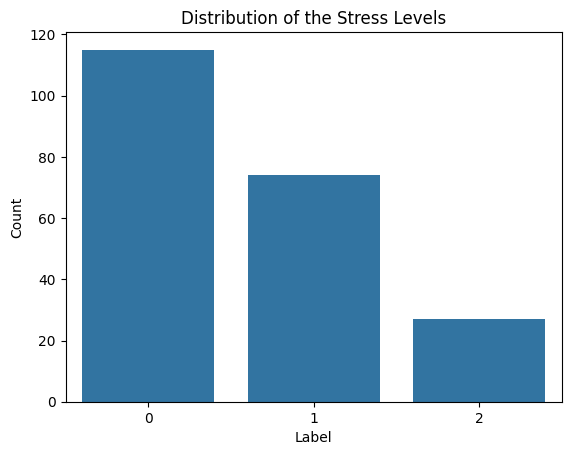

In [12]:
sns.countplot(x='Stress Level', data=data)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of the Stress Levels')
plt.show()

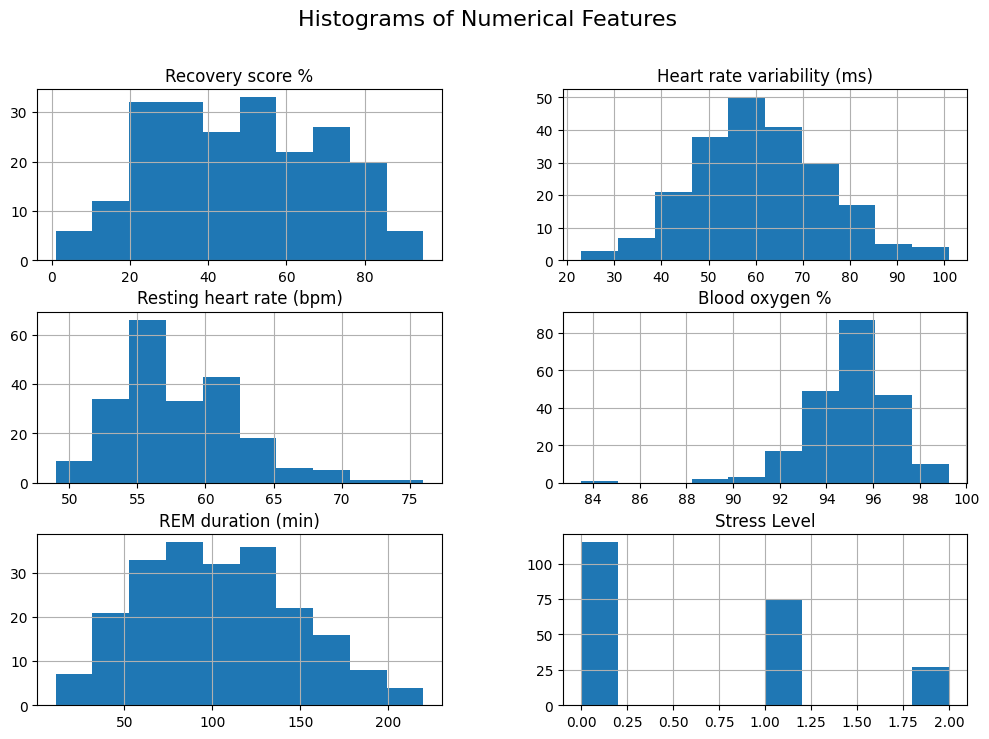

In [13]:
data.hist(figsize=(12, 8))
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()

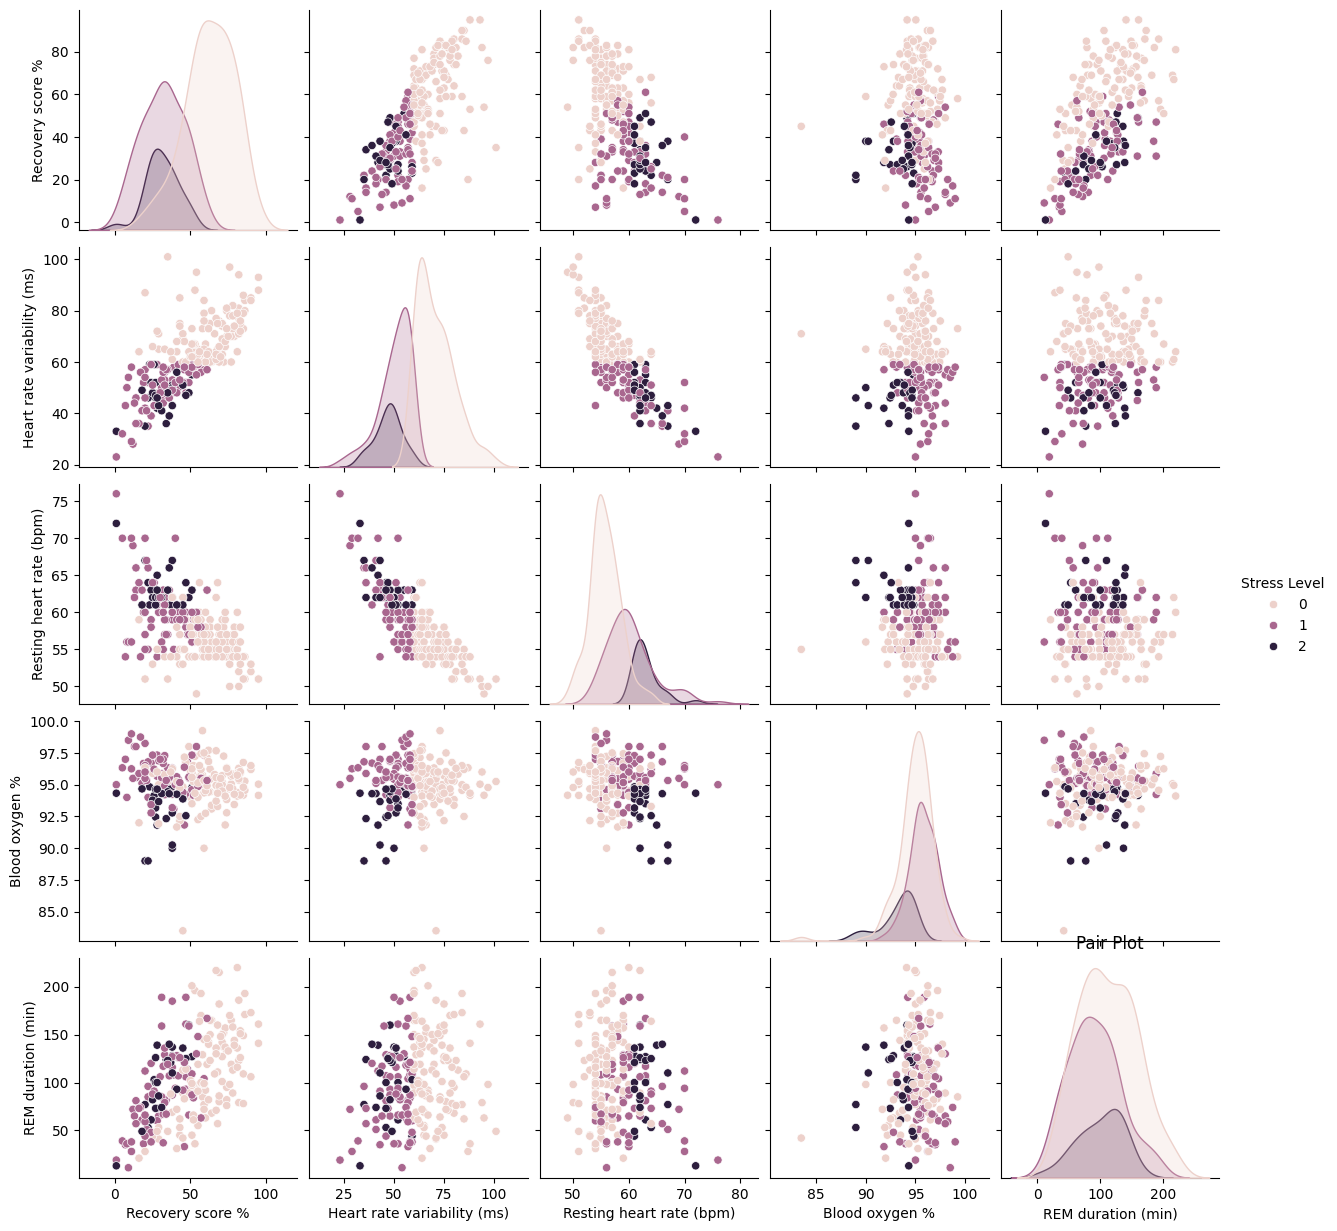

In [14]:
sns.pairplot(data, hue='Stress Level')
plt.title('Pair Plot')
plt.show()

In [15]:
data.head()

,Recovery score %,Heart rate variability (ms),Resting heart rate (bpm),Blood oxygen %,REM duration (min),Stress Level
0,47.0,52.0,59.0,97.00,106.0,1
2,34.0,36.0,62.0,92.33,124.0,2
3,7.0,43.0,54.0,97.00,35.0,1
4,22.0,52.0,55.0,94.00,85.0,1
5,72.0,60.0,57.0,97.25,137.0,0


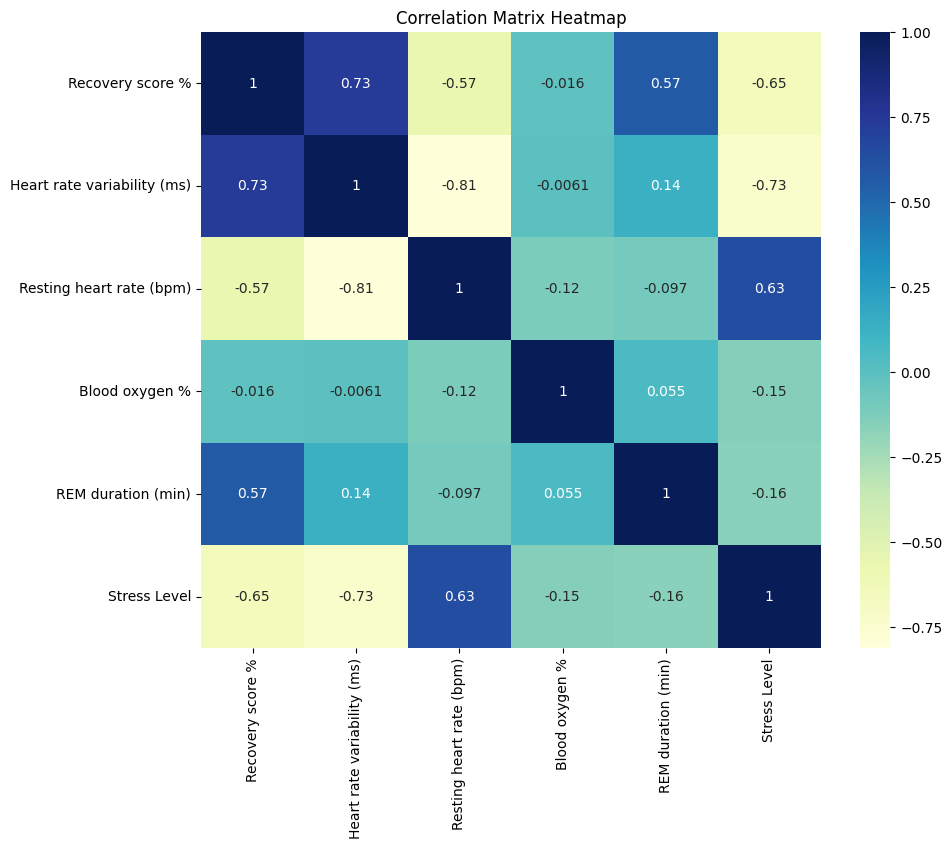

In [16]:
# Correlation Analysis: Correlation matrix heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu')
plt.title("Correlation Matrix Heatmap")
plt.show()

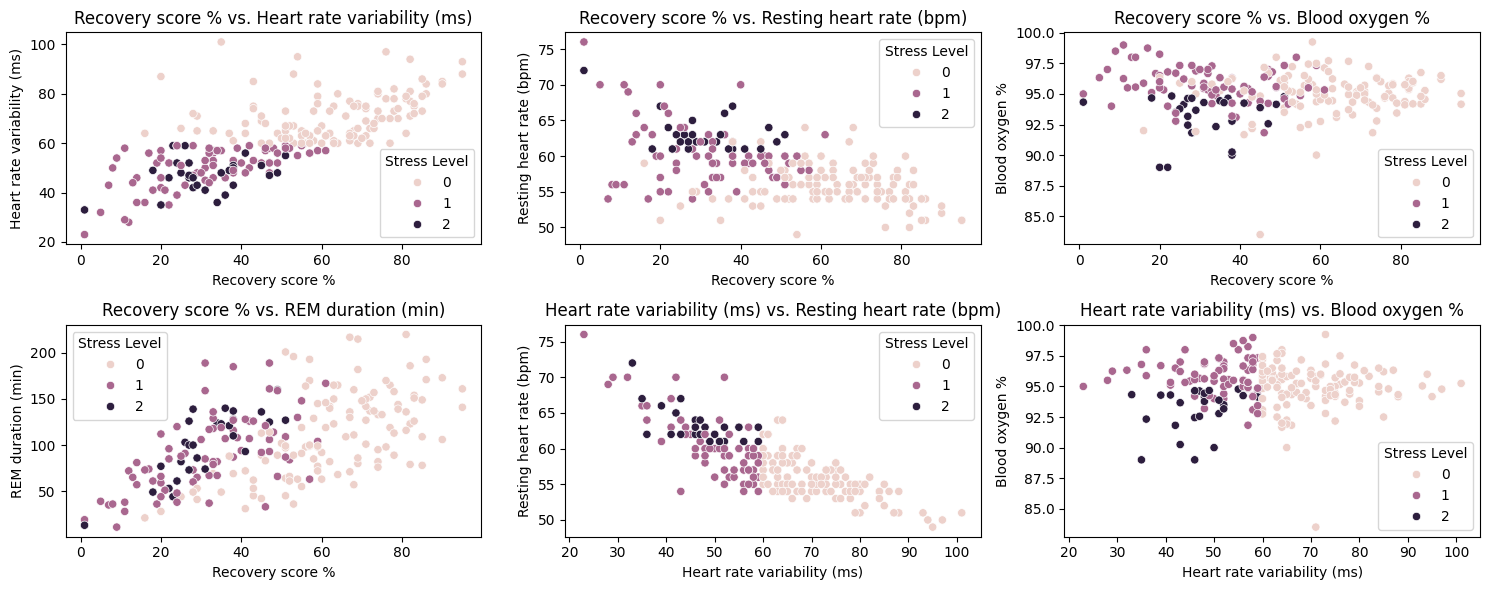

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

features = ['Recovery score %', 'Heart rate variability (ms)',
            'Resting heart rate (bpm)', 'Blood oxygen %', 'REM duration (min)']

cols = 3
rows = 2

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
axes = axes.flatten()

counter = 0
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        if counter < rows * cols:
            sns.scatterplot(ax=axes[counter], data=data, x=features[i], y=features[j], hue='Stress Level')
            axes[counter].set_title(f"{features[i]} vs. {features[j]}")
            counter += 1

for i in range(counter, rows * cols):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


#Dataset Train and Test Split


In [18]:
X = data.drop(['Stress Level'], axis=1)
y = data['Stress Level']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (172, 5)
y_train shape: (172,)
X_test shape: (44, 5)
y_test shape: (44,)


Outlier Analysis

<Axes: >

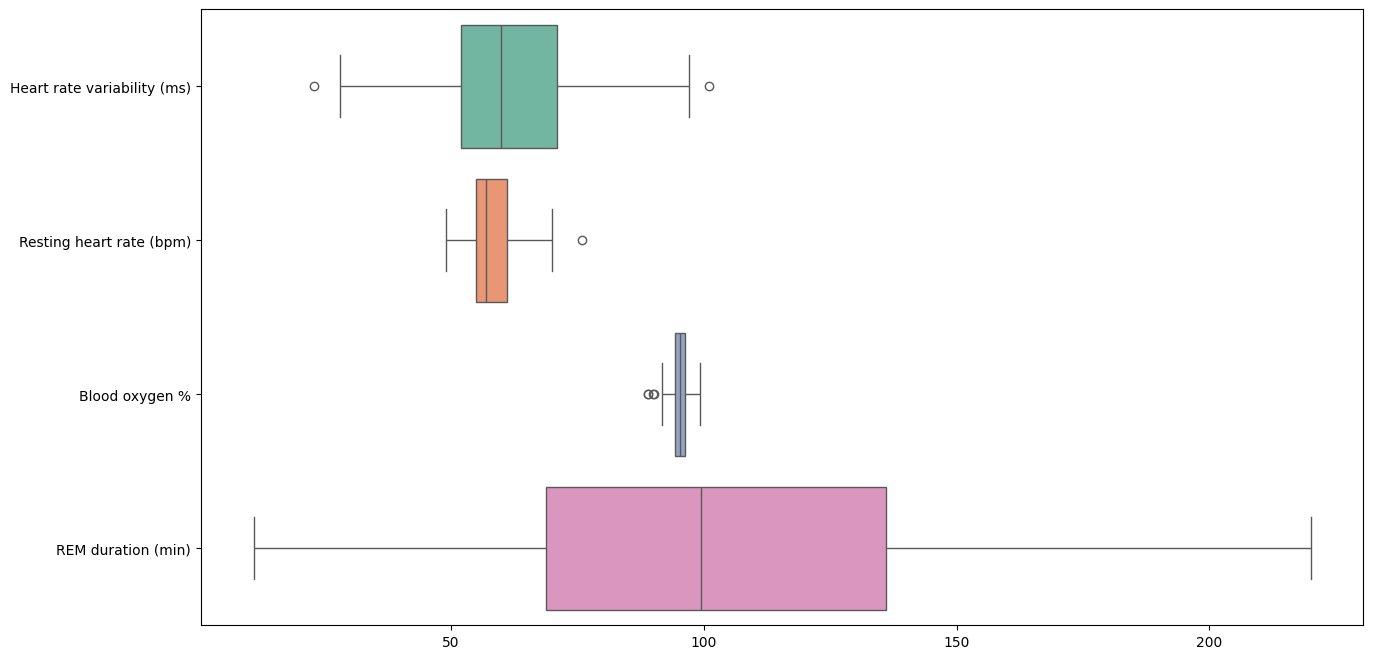

In [20]:
plt.figure(figsize=(15,8))
sns.boxplot(data=X_train.iloc[:,1:], orient='h', palette='Set2')

In [21]:
def scoring(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}.'.format(mae))
    print('Mean Squared Error: {:0.4f}.'.format(mse))
    print('R^2 Score = {:0.4f}.'.format(r2))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

#Feature Importance

In [22]:
forest = RandomForestClassifier(n_estimators=500, random_state=1)

# Train the RandomForestClassifier on the training data
forest.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=500, random_state=1)

In [23]:
importances = forest.feature_importances_

# Loop over each feature and its importance
for i in range(X_train.shape[1]):
    # Print the feature number, name, and importance score
    print("%2d) %-*s %f" % (i + 1, 30, data.columns[i], importances[i]))

 1) Recovery score %               0.184187
 2) Heart rate variability (ms)    0.479083
 3) Resting heart rate (bpm)       0.145034
 4) Blood oxygen %                 0.159204
 5) REM duration (min)             0.032492


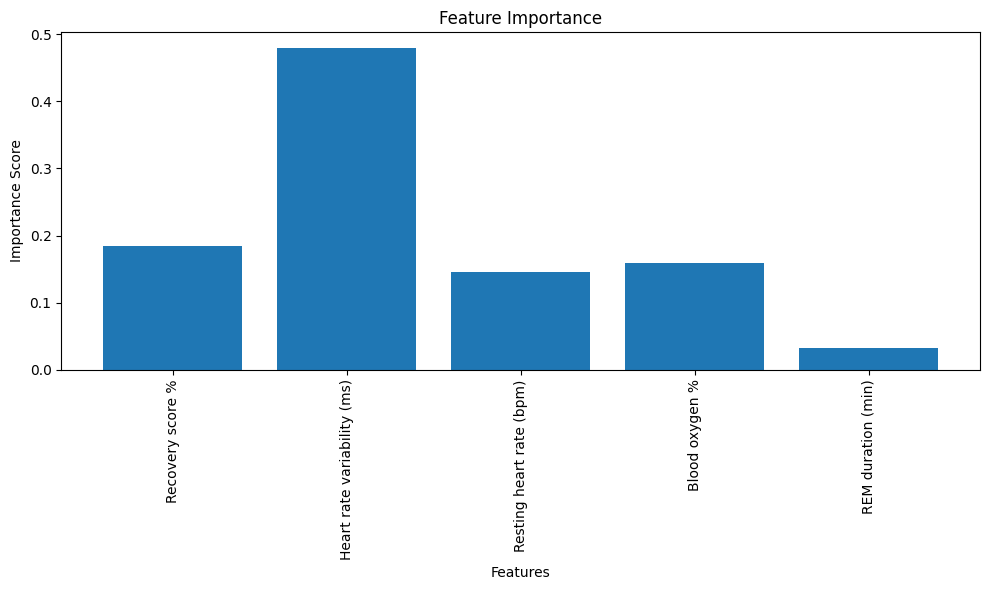

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances, align='center')
plt.title('Feature Importance')
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

In [25]:
# from pycaret.classification import*

In [26]:
# from pycaret.classification import*
# setup(data,target='Stress Level')


In [27]:
# compare_models()

Logistic Regression

In [28]:
log_reg = LogisticRegression(max_iter=1000, C=0.1)

# Training the logistic regression classifier using the training data
# The fit() method is called on the logistic regression object, specifying X_train and y_train as the training data
log_reg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1, max_iter=1000)

In [29]:
log_reg.score(X_test, y_test)

0.8409090909090909

In [30]:
y_predict = log_reg.predict(X_test)

# Calculate the confusion matrix to evaluate the performance of the model
# using the confusion_matrix() function from scikit-learn
# The true labels (y_test) and predicted labels (y_predict) are provided as the parameters
matrix = confusion_matrix(y_test, y_predict)

print("Confusion Matrix:")
print(matrix)

Confusion Matrix:
[[21  0  0]
 [ 0 14  1]
 [ 0  6  2]]


In [31]:
report = classification_report(y_test, y_predict)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.70      0.93      0.80        15
           2       0.67      0.25      0.36         8

    accuracy                           0.84        44
   macro avg       0.79      0.73      0.72        44
weighted avg       0.84      0.84      0.82        44



#Decision Tree Classifier

In [32]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [33]:
decision_tree.score(X_test,y_test)

1.0

In [34]:
y_predict = decision_tree.predict(X_test)

matrix = confusion_matrix(y_test, y_predict)

print("Confusion Matrix:")
print(matrix)

Confusion Matrix:
[[21  0  0]
 [ 0 15  0]
 [ 0  0  8]]


In [35]:
report = classification_report(y_test, y_predict)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00         8

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



#Random Forest Classifier

In [36]:
random_forest = RandomForestClassifier(n_estimators=13)
random_forest.fit(X_train,y_train)

RandomForestClassifier(n_estimators=13)

In [37]:
random_forest.score(X_test, y_test)

0.9772727272727273

In [38]:
from joblib import dump

# Assuming 'rf_model' is your trained Random Forest model
dump(random_forest, 'random_forest_stress_model.joblib')


['random_forest_stress_model.joblib']

In [39]:
y_predict = random_forest.predict(X_test)

matrix = confusion_matrix(y_test, y_predict)

print("Confusion Matrix:")
print(matrix)

Confusion Matrix:
[[21  0  0]
 [ 0 14  1]
 [ 0  0  8]]


In [40]:
report = classification_report(y_test, y_predict)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.93      0.97        15
           2       0.89      1.00      0.94         8

    accuracy                           0.98        44
   macro avg       0.96      0.98      0.97        44
weighted avg       0.98      0.98      0.98        44



#SVM

In [41]:
svm = SVC()
svm.fit(X_train,y_train)

SVC()

In [42]:
svm.score(X_test, y_test)

0.7272727272727273

In [43]:
y_predict = svm.predict(X_test)

matrix = confusion_matrix(y_test, y_predict)

print("Confusion Matrix:")
print(matrix)

Confusion Matrix:
[[19  2  0]
 [ 2 13  0]
 [ 0  8  0]]


In [44]:
report = classification_report(y_test, y_predict)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        21
           1       0.57      0.87      0.68        15
           2       0.00      0.00      0.00         8

    accuracy                           0.73        44
   macro avg       0.49      0.59      0.53        44
weighted avg       0.62      0.73      0.67        44



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#KNN Classifier

In [45]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [46]:
knn.score(X_test, y_test)

0.7272727272727273

In [47]:
y_predict = knn.predict(X_test)

matrix = confusion_matrix(y_test, y_predict)

print("Confusion Matrix:")
print(matrix)

Confusion Matrix:
[[20  1  0]
 [ 2 10  3]
 [ 0  6  2]]


In [48]:
report = classification_report(y_test, y_predict)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        21
           1       0.59      0.67      0.62        15
           2       0.40      0.25      0.31         8

    accuracy                           0.73        44
   macro avg       0.63      0.62      0.62        44
weighted avg       0.71      0.73      0.71        44



#Gaussian Naives Bayes

In [49]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train,y_train)

GaussianNB()

In [50]:
naive_bayes.score(X_test, y_test)

0.7954545454545454

In [51]:
y_predict = naive_bayes.predict(X_test)
matrix = confusion_matrix(y_test, y_predict)
print(matrix)

[[20  0  1]
 [ 3 11  1]
 [ 0  4  4]]


In [52]:
report = classification_report(y_test, y_predict)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        21
           1       0.73      0.73      0.73        15
           2       0.67      0.50      0.57         8

    accuracy                           0.80        44
   macro avg       0.76      0.73      0.74        44
weighted avg       0.79      0.80      0.79        44



In [55]:
new_data = pd.DataFrame([[75.0, 45.0, 56.0, 94.0, 40.0 ]], columns=X.columns)

# Predict the stress level for the new data
predicted_stress_level = random_forest.predict(new_data)

# Dictionary to map integer stress levels to human-readable labels
stress_level_labels = {
    0: "Low/Normal",
    1: "Medium",
    2: "High",

}

# Assuming you already have the 'predicted_stress_level' from the previous code snippet
predicted_stress_label = stress_level_labels[predicted_stress_level[0]]

# Display the human-readable label for the predicted stress level
print("Predicted Stress Label for New Data:",predicted_stress_level[0],"(",predicted_stress_label,")")
# print(predicted_stress_level)

Predicted Stress Label for New Data: 1 ( Medium )


In [56]:
clf = GradientBoostingClassifier(n_estimators=20, random_state = 0)
clf.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=20, random_state=0)

In [57]:
clf.score(X_test, y_test)

1.0

In [58]:
!pip install pycaret

In [59]:
from pycaret.classification import*
setup(data,target='Stress Level')

,Description,Value
0,Session id,4356
1,Target,Stress Level
2,Target type,Multiclass
3,Original data shape,"(216, 6)"
4,Transformed data shape,"(216, 6)"
5,Transformed train set shape,"(151, 6)"
6,Transformed test set shape,"(65, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [60]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4340
lightgbm,Light Gradient Boosting Machine,0.9938,1.0000,0.9938,0.9958,0.9941,0.9897,0.9903,0.3520
dt,Decision Tree Classifier,0.9933,0.9950,0.9933,0.9944,0.9925,0.9884,0.9891,0.0810
rf,Random Forest Classifier,0.9933,0.9995,0.9933,0.9944,0.9925,0.9884,0.9891,0.4540
gbc,Gradient Boosting Classifier,0.9933,0.0000,0.9933,0.9944,0.9925,0.9884,0.9891,0.5330
xgboost,Extreme Gradient Boosting,0.9933,0.9988,0.9933,0.9944,0.9925,0.9884,0.9891,0.1420
et,Extra Trees Classifier,0.9342,0.9901,0.9342,0.9349,0.9264,0.8872,0.8968,0.3690
lr,Logistic Regression,0.8879,0.0000,0.8879,0.8960,0.8814,0.8084,0.8174,1.4840
nb,Naive Bayes,0.8550,0.9445,0.8550,0.8677,0.8495,0.7545,0.7649,0.1220
qda,Quadratic Discriminant Analysis,0.8083,0.0000,0.8083,0.8046,0.7936,0.6685,0.6828,0.0690


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

AdaBoostClassifier(algorithm='SAMME.R', estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=4356)

In [61]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

# Assume X, y are your data and labels
X, y = make_classification(n_samples=1000, n_features=20,
                           n_informative=2, n_redundant=0,
                           random_state=42)

# Create AdaBoost classifier object
ada_clf = AdaBoostClassifier(n_estimators=100)

# Train AdaBoost Classifer
model = ada_clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = model.predict(X_test)


In [62]:
model.score(X_test, y_test)

1.0

In [63]:
report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report of AdaBoost Classifier:")
print(report)

Classification Report of AdaBoost Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00         8

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44

